In [1]:
%matplotlib inline
from utils import utils
import canny_edge_detector as ced
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from myfuncs import funcs
import cv2 as cv

In [3]:
dir_name = "Images/Inputs/Set1"
imgs = utils.load_data(dir_name)

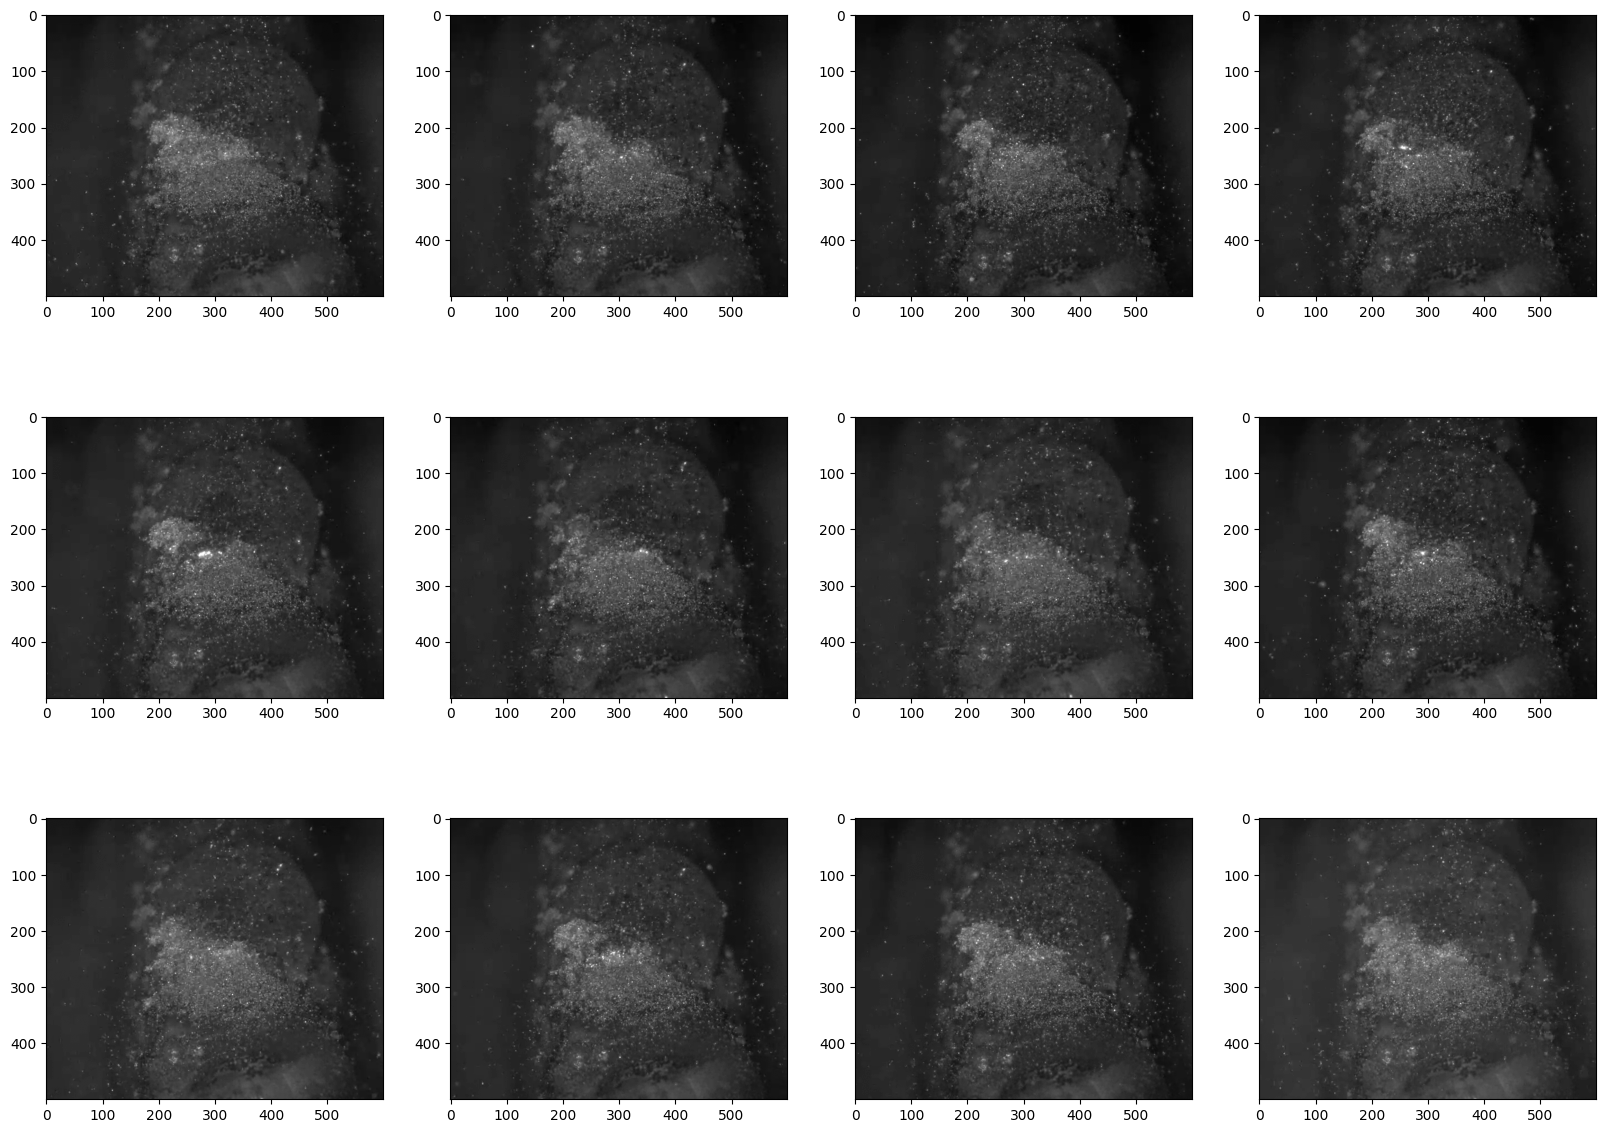

In [3]:
utils.visualize(imgs, "gray")

In [4]:
#detector = ced.cannyEdgeDetector(imgs, sigma=3, kernel_size=9, lowthreshold=0.05, highthreshold=0.22, weak_pixel=200)
#imgs_final = detector.detect()
#utils.visualize(imgs_final, 'gray')

In [4]:
detector = ced.cannyEdgeDetector(imgs, sigma=10, kernel_size=72, lowthreshold=0.08, highthreshold=0.20, weak_pixel=50)

In [5]:
imgs_final = detector.detect()

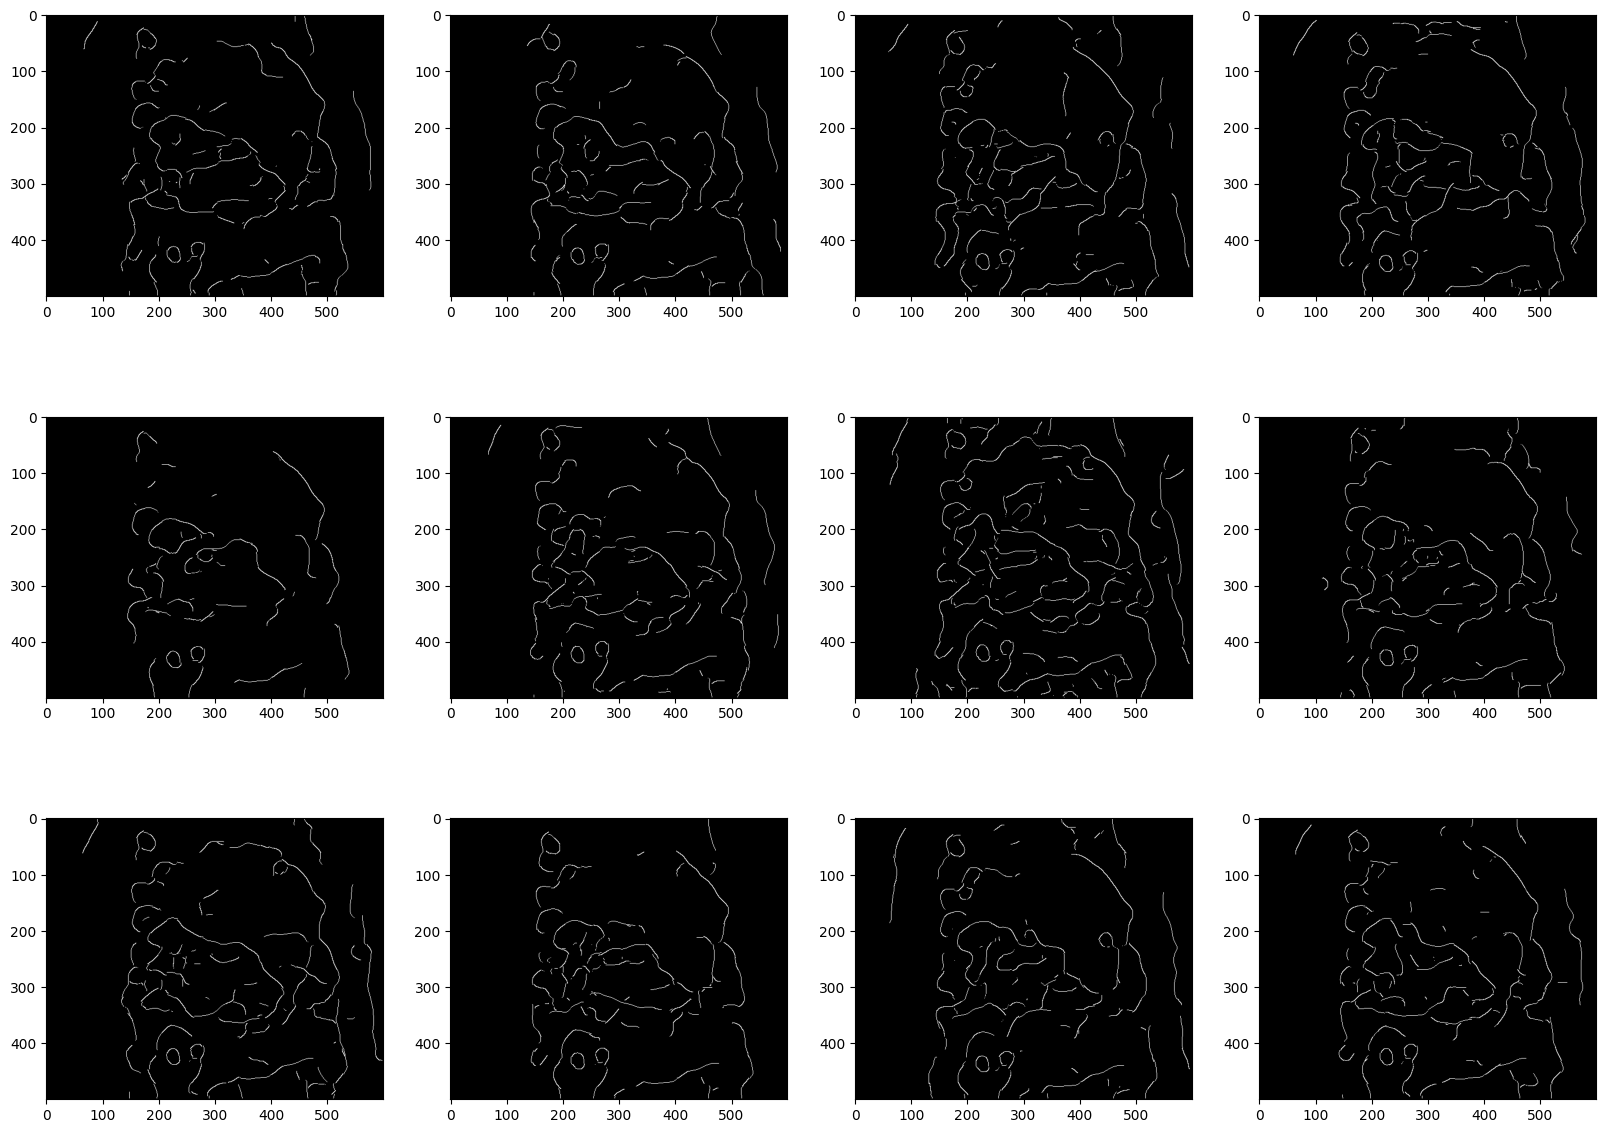

In [6]:
utils.visualize(imgs_final, 'gray')

In [7]:
im_test = Image.open("Images/Inputs/Set2/20240816-161944712534-0014.png")

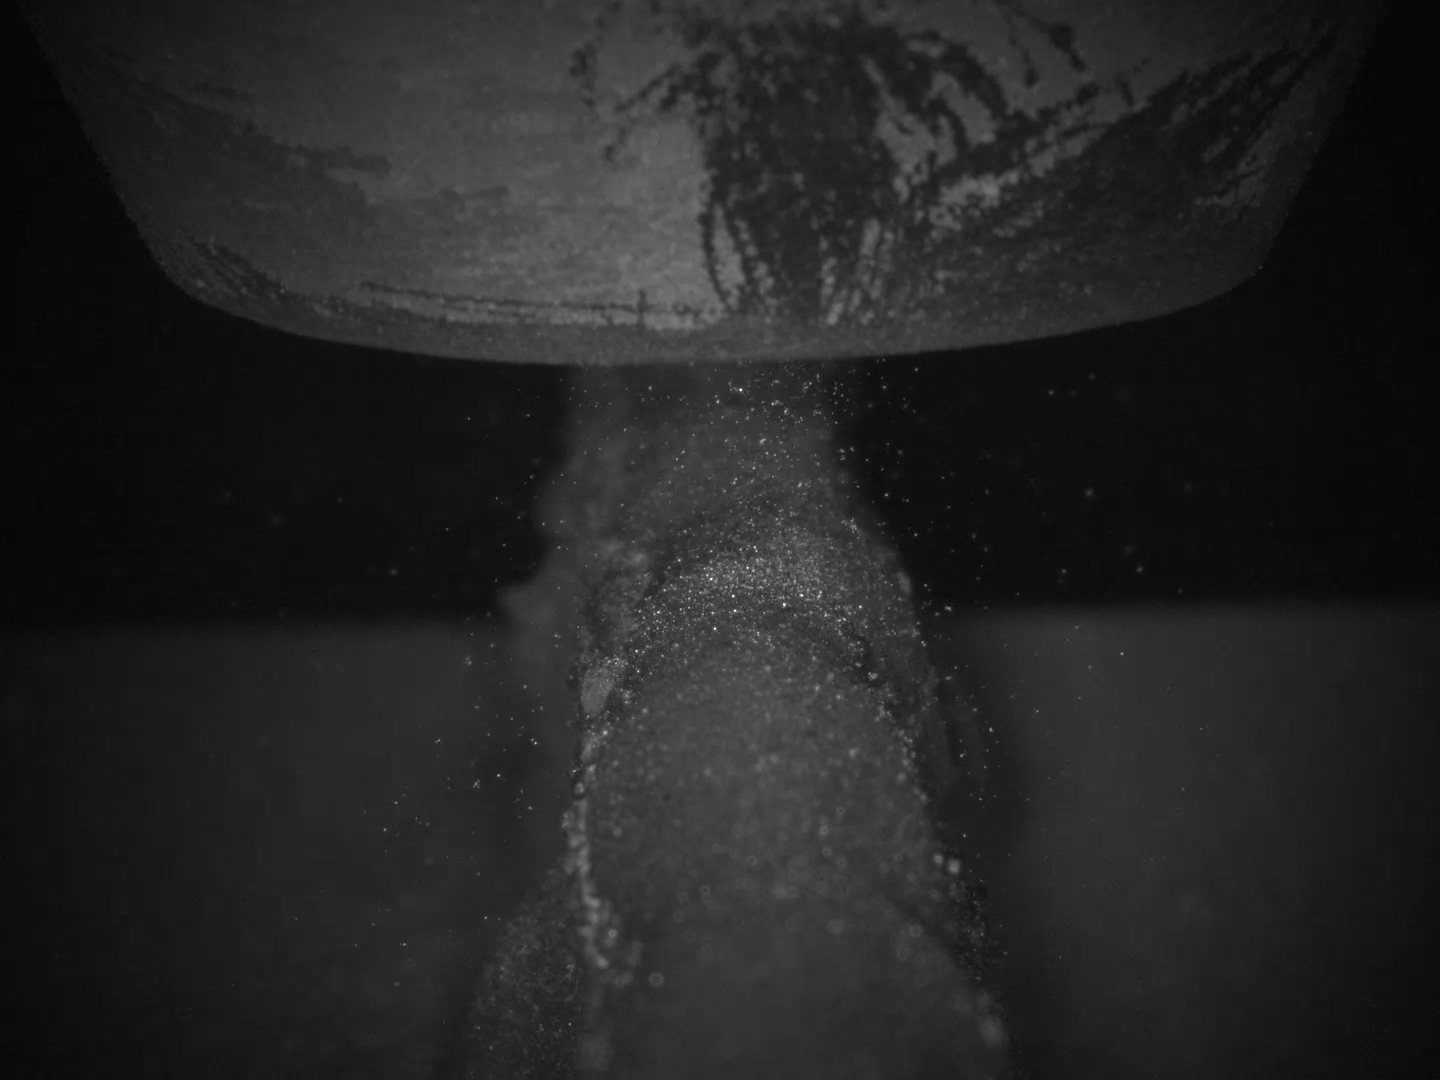

In [8]:
display(im_test)

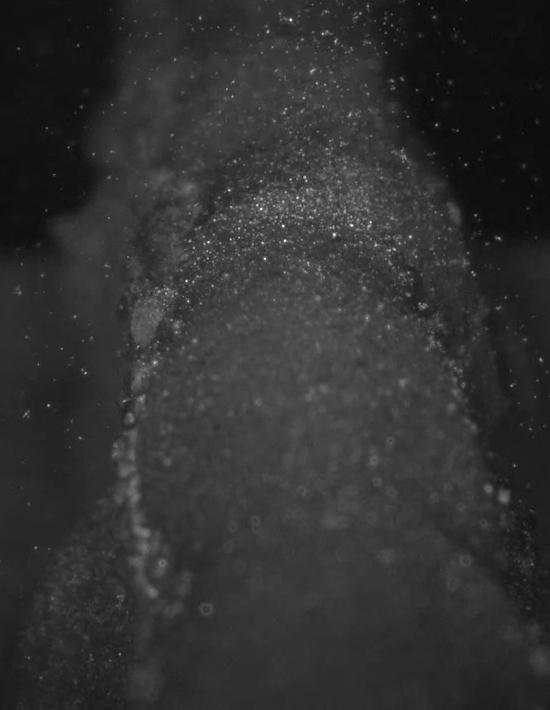

In [9]:
im_crop = im_test.crop((450,370,1000,1080)) #image was 1920x1080
display(im_crop)

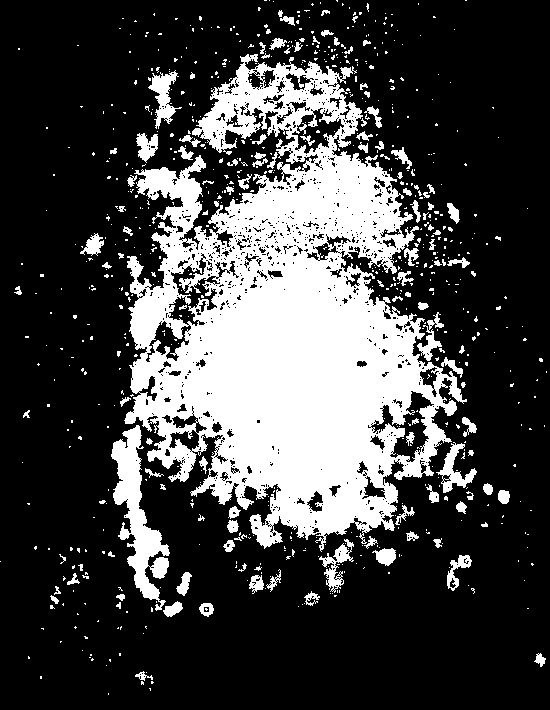

In [10]:
im_grey = im_crop.convert('L')
threshold = 60
im_thresh = im_grey.point(lambda p : 255 if p > threshold else 0)
display(im_thresh)

In [11]:
im_thresh.getpixel((0,0))

0

In [26]:
%matplotlib auto

Using matplotlib backend: <object object at 0x10f3ab460>


## Using OpenCV for video

In [54]:
vid = cv.VideoCapture('Vids/VID_topview.webm')
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('output.mp4', fourcc, 30.0, (int(vid.get(3)), int(vid.get(4))), isColor=False)

if (vid.isOpened() == False):
    print("Error opening video stream or file")

while (vid.isOpened()):
    (ret, frame) = vid.read()
    if ret == True:
        #cv.imshow('Frame', frame)
        frame = cv.GaussianBlur(frame, (15, 15), 5)
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        edge = cv.Canny(frame, 8, 14)

        out.write(edge)
        cv.imshow('Edge Detection', edge)

    else:
        break


    if cv.waitKey(25) & 0xFF == ord('q'):
        break


vid.release()
out.release()

cv.waitKey(1)
cv.destroyAllWindows()
for i in range (1,5):
    cv.waitKey(1)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [52]:
total_frames = vid.get(cv.CAP_PROP_FRAME_)
total_frames

0.0

## Finetuning Canny with OpenCV

Reading images an cropping to ROI

In [2]:
im1 = cv.imread('Images/Inputs/topview/VID_topview-0001.png', cv.IMREAD_GRAYSCALE)
im2 = cv.imread('Images/Inputs/topview/VID_topview-0002.png', cv.IMREAD_GRAYSCALE)
roi1 = im1[250:850, 420:1020]
roi2 = im2[250:850, 420:1020]

In [10]:
roi2.shape

(600, 600)

Normalizing images

In [14]:
roi1_norm = cv.normalize(roi1, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
roi2_norm = cv.normalize(roi2, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

Equalizing images

In [4]:
equ1 = cv.equalizeHist(roi1_norm)
equ2 = cv.equalizeHist(roi2_norm)

Creating histograms to analyse images

In [5]:
hist1 = cv.calcHist([roi1], [0], None, [256], [0, 256]) # image 1
hist2 = cv.calcHist([roi2], [0], None, [256], [0, 256]) # image 2
hist3 = cv.calcHist([roi1_norm], [0], None, [256], [0, 256]) # normed image 1
hist4 = cv.calcHist([roi2_norm], [0], None, [256], [0, 256]) # normed image 2
hist5 = cv.calcHist([equ1], [0], None, [256], [0, 256]) # equalized image 1
hist6 = cv.calcHist([equ2], [0], None, [256], [0, 256]) # equalized image 2

Plotting

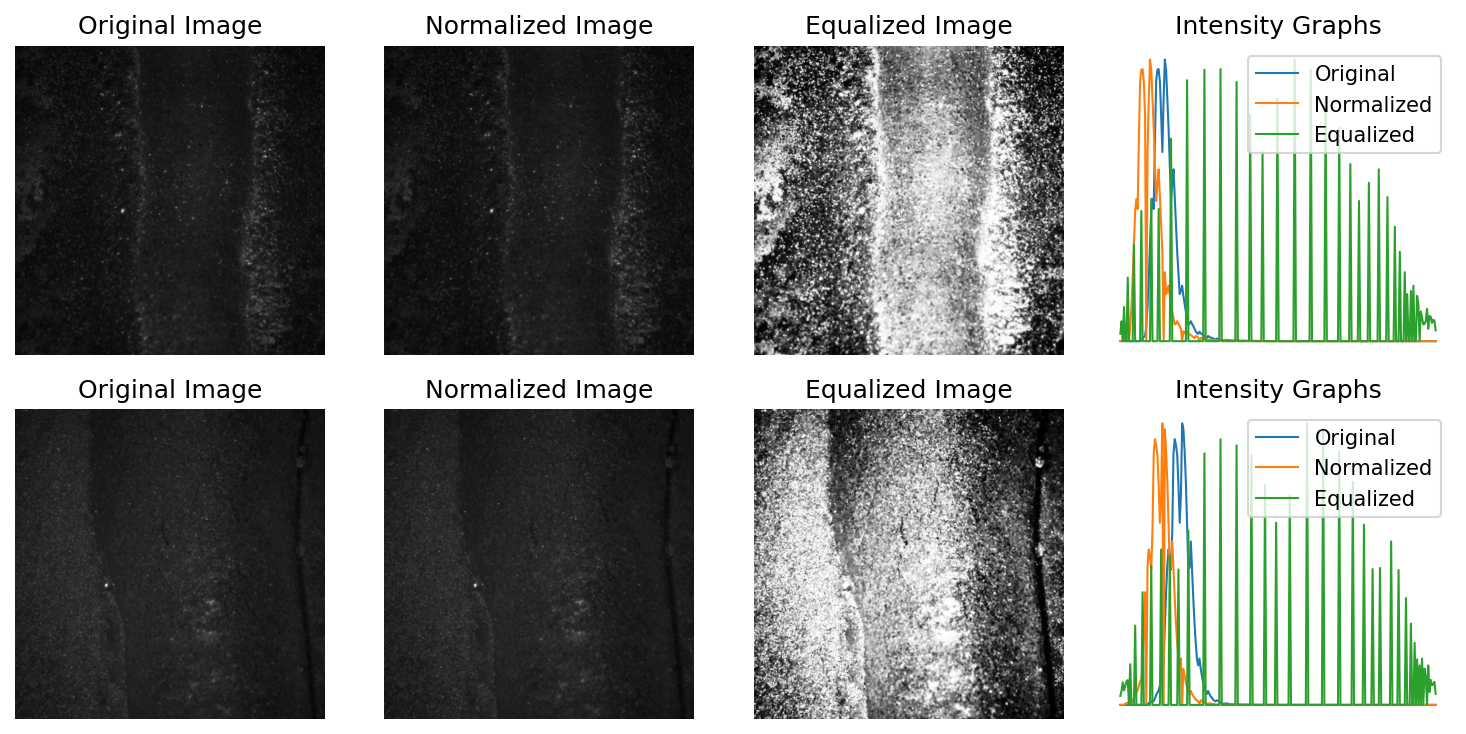

In [8]:
fig, axs = plt.subplots(2, 4, dpi=150, figsize=(10,5), layout='tight')

# turn off axes
for i in range(2):
    for j in range(4):
        axs[i, j].set_axis_off()

lw=1 # linewidth for line plots

axs[0, 0].set_title('Original Image')
axs[0, 0].imshow(roi1, cmap='grey')
axs[0, 1].set_title('Normalized Image')
axs[0, 1].imshow(roi1_norm, cmap='grey')
axs[0, 2].set_title('Equalized Image')
axs[0, 2].imshow(equ1, cmap='grey')
axs[0, 3].set_title('Intensity Graphs')
axs[0, 3].plot(hist1, label='Original', lw=lw)
axs[0, 3].plot(hist3, label='Normalized', lw=lw)
axs[0, 3].plot(hist5, label='Equalized', lw=lw)
axs[0, 3].legend(loc='upper right')

axs[1, 0].set_title('Original Image')
axs[1, 0].imshow(roi2, cmap='grey')
axs[1, 1].set_title('Normalized Image')
axs[1, 1].imshow(roi2_norm, cmap='grey')
axs[1, 2].set_title('Equalized Image')
axs[1, 2].imshow(equ2, cmap='grey')
axs[1, 3].set_title('Intensity Graphs')
axs[1, 3].plot(hist2, label='Original', lw=lw)
axs[1, 3].plot(hist4, label='Normalized', lw=lw)
axs[1, 3].plot(hist6, label='Equalized', lw=lw)
axs[1, 3].legend(loc='upper right')

fig.tight_layout()

Now we can look for optimized canny parameters

Creating a combined canny function

In [18]:
def cv_Canny(img, sigma, kernel_size, low_thresh, hi_thresh):
    img_blur = cv.GaussianBlur(img, dst=None, ksize=(kernel_size, kernel_size), sigmaX=sigma)
    img_canny = cv.Canny(img_blur, low_thresh, hi_thresh)
    return img_canny

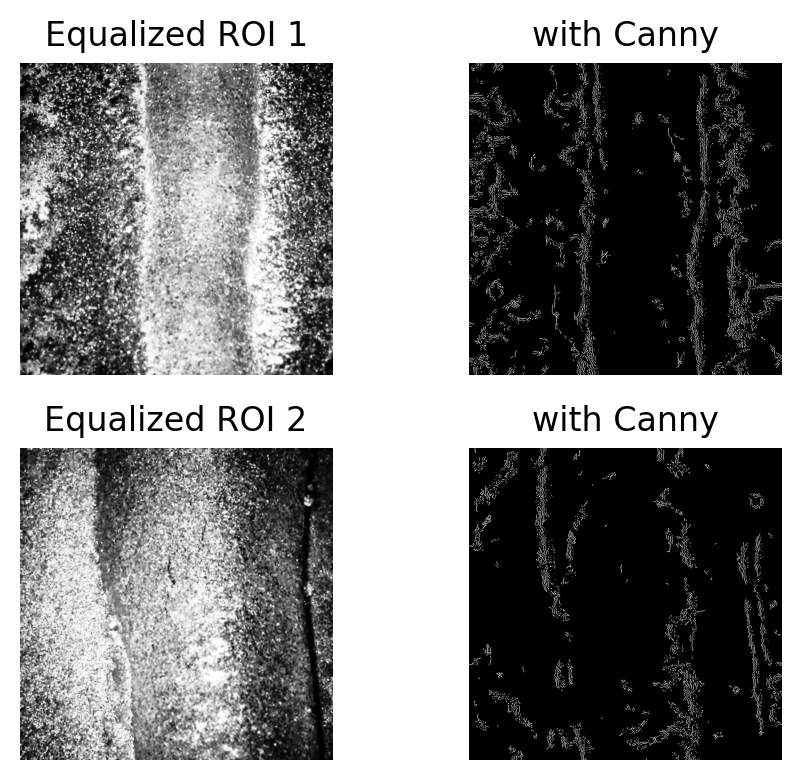

In [10]:
sig = 10
kern = 71
lo_th = 15 
hi_th = 20 # 20

equ1_canny = cv_Canny(equ1, sigma=sig, kernel_size=kern, low_thresh=lo_th, hi_thresh=hi_th)
equ2_canny = cv_Canny(equ2, sigma=sig, kernel_size=kern, low_thresh=lo_th, hi_thresh=hi_th)

images = [equ1, equ1_canny, equ2, equ2_canny]
titles = ['Equalized ROI 1', 'with Canny', 'Equalized ROI 2', 'with Canny']

fig, ax = plt.subplots(2,2, dpi=200, figsize=(5,4))

for i, this_ax in enumerate(ax.flatten()):
    this_ax.set_axis_off()
    this_ax.imshow(images[i], cmap='grey')
    this_ax.set_title(titles[i])

fig.tight_layout()

### A Canny Parameter selection tool

In [16]:
test_image = roi2_norm # feed only grayscale images!
window_name = 'Canny Tester'
trackbar_sigma = 'Sigma'
max_sigma = 100
trackbar_kernel = ' Kernel Size'
max_kernel = 201
trackbar_lo_thresh = 'Low'
trackbar_hi_thresh = 'High'
max_value = 255

def Canny_Demo(val):

    sigma = cv.getTrackbarPos(trackbar_sigma, window_name)
    kernel = cv.getTrackbarPos(trackbar_kernel, window_name)
    kernel = (int(kernel/2)*2)+1 # ensures kernel is always odd
    lo = cv.getTrackbarPos(trackbar_lo_thresh, window_name)
    hi = cv.getTrackbarPos(trackbar_hi_thresh, window_name)
    blur = cv.GaussianBlur(test_image, (kernel, kernel), sigma)
    canny = cv.Canny(blur, lo, hi)
    cv.imshow(window_name, canny)

cv.namedWindow(window_name)

cv.createTrackbar(trackbar_sigma, window_name, 0, max_sigma, Canny_Demo )
cv.createTrackbar(trackbar_kernel, window_name , 3, max_kernel, Canny_Demo)
cv.createTrackbar(trackbar_lo_thresh, window_name , 0, max_value, Canny_Demo)
cv.createTrackbar(trackbar_hi_thresh, window_name , 0, max_value, Canny_Demo)

# Call the function to initialize
Canny_Demo(0)
# Wait until user finishes program
cv.waitKey()

cv.destroyAllWindows()
for i in range (1,5):
    cv.waitKey(1)

Optimized parameters found as:

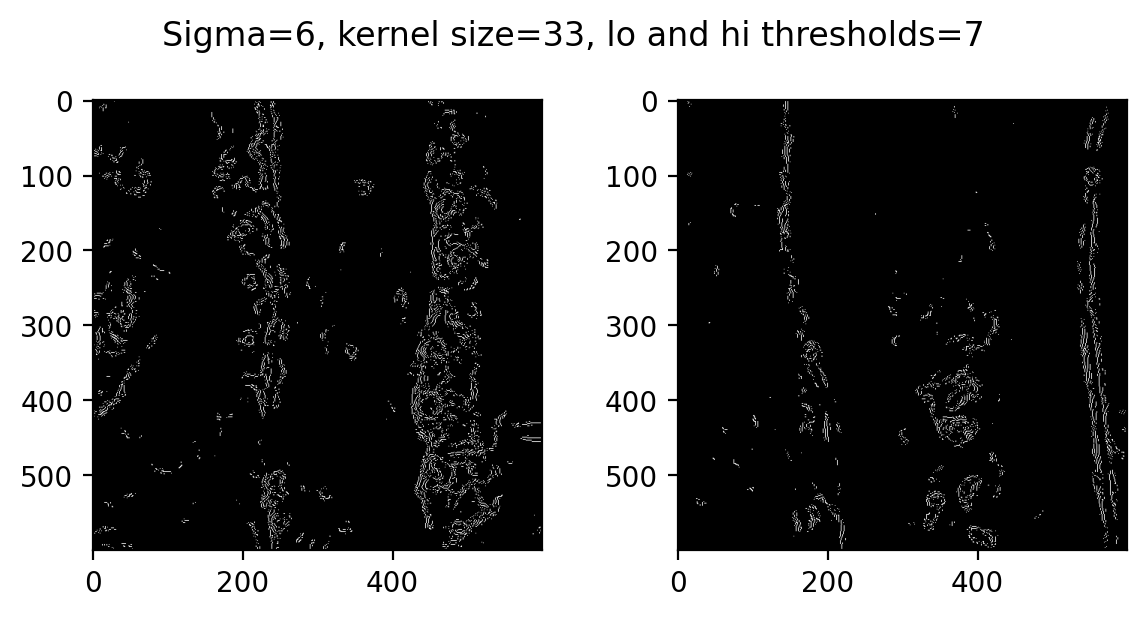

In [32]:
fig, axs = plt.subplots(1,2, figsize=(6,3), dpi=200)
fig.suptitle('Sigma=6, kernel size=33, lo and hi thresholds=7')
axs[0].imshow(cv_Canny(roi1_norm, 6, 33, 7, 7), cmap='grey')
axs[1].imshow(cv_Canny(roi2_norm, 6, 33, 7, 7), cmap='grey')
fig.tight_layout()

In [195]:
from __future__ import print_function
import cv2 as cv
import argparse

max_value = 255
max_type = 4
max_binary_value = 255
trackbar_type = 'Type: \n 0: Binary \n 1: Binary Inverted \n 2: Truncate \n 3: To Zero \n 4: To Zero Inverted'
trackbar_value = 'Value'
window_name = 'Threshold Demo'
def Threshold_Demo(val):
    #0: Binary
    #1: Binary Inverted
    #2: Threshold Truncated
    #3: Threshold to Zero
    #4: Threshold to Zero Inverted
    threshold_type = cv.getTrackbarPos(trackbar_type, window_name)
    threshold_value = cv.getTrackbarPos(trackbar_value, window_name)
    _, dst = cv.threshold(src_gray, threshold_value, max_binary_value, threshold_type )
    cv.imshow(window_name, dst)

parser = argparse.ArgumentParser(description='Code for Basic Thresholding Operations tutorial.')
parser.add_argument('--input', help='Path to input image.', default='stuff.jpg')
args = parser.parse_args()
src = cv.imread(cv.samples.findFile(args.input))

if src is None:
    print('Could not open or find the image: ', args.input)
    exit(0)

# Convert the image to Gray
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
cv.namedWindow(window_name)
cv.createTrackbar(trackbar_type, window_name , 3, max_type, Threshold_Demo)
# Create Trackbar to choose Threshold value
cv.createTrackbar(trackbar_value, window_name , 0, max_value, Threshold_Demo)
# Call the function to initialize
Threshold_Demo(0)
# Wait until user finishes program
cv.waitKey()

usage: ipykernel_launcher.py [-h] [--input INPUT]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/sid/Library/Jupyter/runtime/kernel-v3c00f3cc64fc87d7526f126e53b7a834fa7929aee.json


SystemExit: 2

/Users/sid/opt/anaconda3/envs/3dpmd/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [101]:
vid = cv.VideoCapture('Vids/VID_topview.webm')
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('output2.mp4', fourcc, 30.0, (int(vid.get(3)), int(vid.get(4))), isColor=False)

if (vid.isOpened() == False):
    print("Error opening video stream or file")

while (vid.isOpened()):
    (ret, frame) = vid.read()
    if ret == True:
        #cv.imshow('Frame', frame) # show opened frame
        frame = frame[250:850, 420:1020] # crop
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frame = cv.equalizeHist(frame)
        frame = cv.GaussianBlur(frame, (kern, kern), sig)
        edge = cv.Canny(frame, lo_th, hi_th)

        out.write(edge)
        cv.imshow('Edge Detection', edge)

    else:
        break


    if cv.waitKey(25) & 0xFF == ord('q'):
        break


vid.release()
out.release()

cv.waitKey(1)
cv.destroyAllWindows()
for i in range (1,5):
    cv.waitKey(1)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


## Statistical analysis for images

### Image 1

Choosing a particular row to analyse

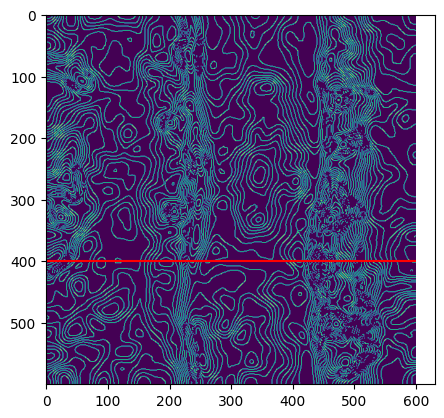

In [94]:
selected_row = 400
plt.imshow(roi1_norm_canny)
plt.hlines(selected_row, xmin=0, xmax = roi1_norm_canny.shape[0], color='red')

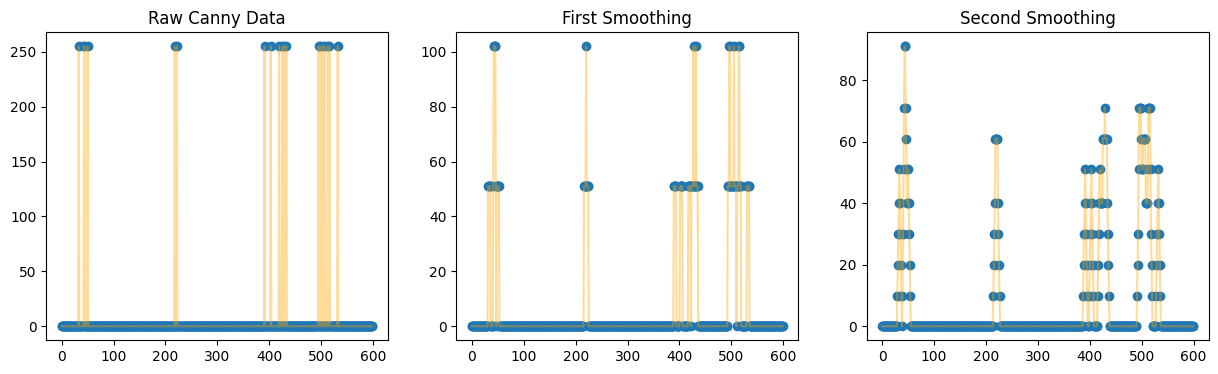

In [90]:
cols = equ1_canny.shape[1] # get cols since we want to evaluate values over the row
window = 5
row_values = eq1_canny.T[selected_row].T
smooth1 = funcs.smoother(selected_row, window)
smooth2 = funcs.smoother(smooth1, window)

titles = ['Raw Canny Data', 'First Smoothing', 'Second Smoothing']
y_vals = [selected_row, smooth1, smooth2]

fig, ax = plt.subplots(1,3, figsize = (15,4))
for i in range(3):
    ax[i].set_title(titles[i])
    ax[i].scatter(x=np.arange(cols), y=y_vals[i])
    ax[i].plot(y_vals[i], color='orange', alpha = 0.4)

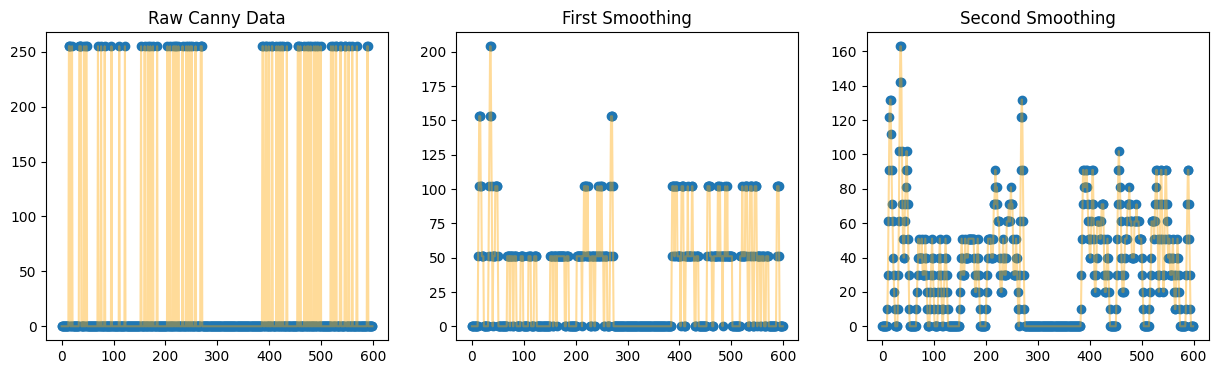

In [91]:
_, cols = roi1_norm_canny.shape
window = 5
selected_row = roi1_norm_canny[400]
smooth1 = funcs.smoother(selected_row, window)
smooth2 = funcs.smoother(smooth1, window)

titles = ['Raw Canny Data', 'First Smoothing', 'Second Smoothing']
y_vals = [selected_row, smooth1, smooth2]

fig, ax = plt.subplots(1,3, figsize = (15,4))

for i in range(3):
    ax[i].set_title(titles[i])
    ax[i].scatter(x=np.arange(cols), y=y_vals[i])
    ax[i].plot(y_vals[i], color='orange', alpha = 0.4)

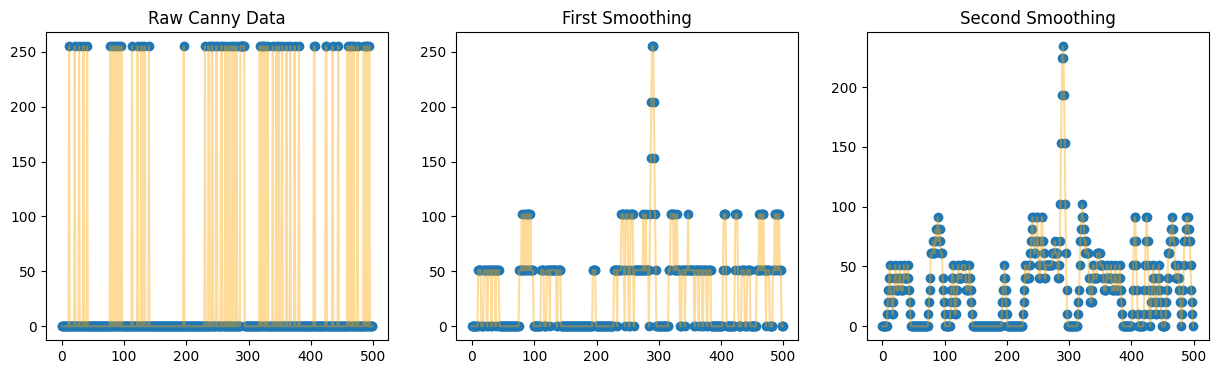

In [92]:
_, cols = roi2_norm_canny.shape
window = 5
selected_row = roi2_norm_canny[400]
smooth1 = funcs.smoother(selected_row, window)
smooth2 = funcs.smoother(smooth1, window)

titles = ['Raw Canny Data', 'First Smoothing', 'Second Smoothing']
y_vals = [selected_row, smooth1, smooth2]

fig, ax = plt.subplots(1,3, figsize = (15,4))

for i in range(3):
    ax[i].set_title(titles[i])
    ax[i].scatter(x=np.arange(cols), y=y_vals[i])
    ax[i].plot(y_vals[i], color='orange', alpha = 0.4)

In [88]:
roi2_norm_canny[400].size == roi2_norm_canny.shape[0]

False

In [89]:
roi2_norm_canny.shape[0]

600

(array([  4.,  14.,  21.,  84., 325.,  88.,  39.,  15.,   8.,   2.]),
 array([-35.5, -27.9, -20.3, -12.7,  -5.1,   2.5,  10.1,  17.7,  25.3,
         32.9,  40.5]),
 <BarContainer object of 10 artists>)

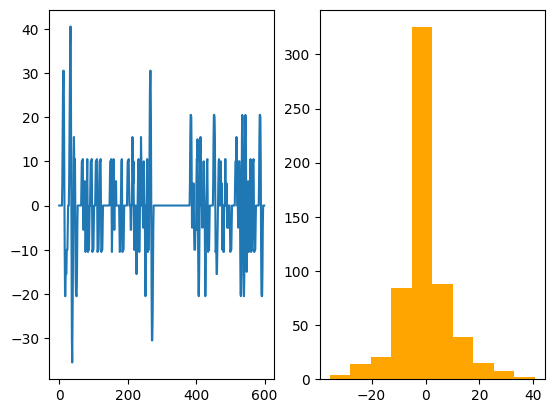

In [48]:
fig, ax = plt.subplots(1,2)

ax[0].plot(np.gradient(smooth2, 1))
ax[1].hist(np.gradient(smooth2, 1), color='orange')

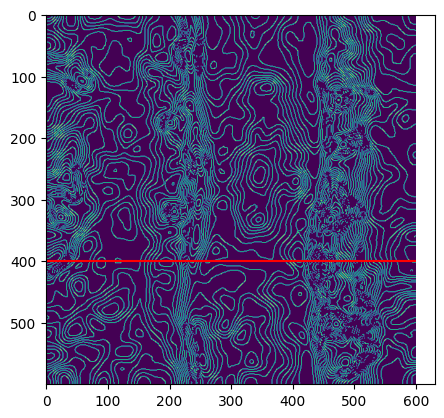

In [74]:
plt.imshow(roi1_norm_canny)
plt.hlines(400, xmin=0, xmax = roi1_norm_canny.shape[0], color='red')


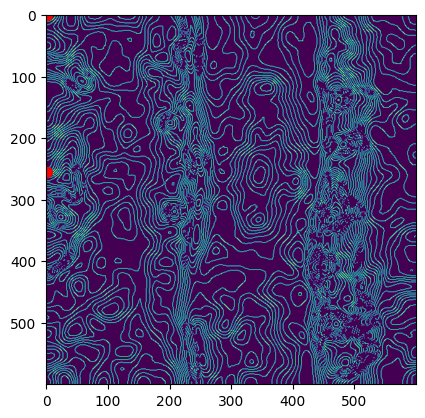

In [100]:
plt.imshow(roi1_norm_canny)
x_vals = np.arange
plt.scatter(x = np.arangenp.ones_like(equ1_canny[selected_row]), y = equ1_canny[400], color='red')


In [ ]:
plt.scatter(np.arange())

In [118]:
foo = np.ones(4)
foo_fix = np.append([0,0], foo)
foo_fix = np.append(foo_fix, [0])
foo_fix

array([0., 0., 1., 1., 1., 1., 0.])

In [119]:
np.average(foo_fix)

0.5714285714285714